In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Data Preparation

In [18]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [20]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [21]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [22]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']
Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']


In [23]:
for col in categorical_columns:
    df[col] = df[col].fillna('NA')

for col in numerical_columns:
    df[col] = df[col].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [28]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

print(f"Train size: {len(y_train)}")
print(f"Validation size: {len(y_val)}")
print(f"Test size: {len(y_test)}")

Train size: 876
Validation size: 293
Test size: 293


## Question 1: ROC AUC Feature Importance

ROC AUC can be used to evaluate feature importance of numerical variables.

For each numerical variable, we'll:
1. Use it as a score (prediction)
2. Compute the AUC with y as ground truth
3. If AUC < 0.5, invert the variable (negative correlation)

Which numerical variable has the highest AUC among:
- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [29]:
features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for feature in features:
    score = df_train[feature].values
    auc = roc_auc_score(y_train, score)
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        print(f'{feature:30s}: {auc:.3f} (inverted)')
    else:
        print(f'{feature:30s}: {auc:.3f}')

lead_score                    : 0.614
number_of_courses_viewed      : 0.764
interaction_count             : 0.738
annual_income                 : 0.552


## Question 2: Training the Model

Train a logistic regression model using:
- All categorical features (after one-hot encoding)
- All numerical features

What's the AUC on the validation dataset? (round to 3 digits)

In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [31]:
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

In [32]:
model = LogisticRegression(max_iter=1000, random_state=1)
model.fit(X_train, y_train)

/Users/oleksandrz/dev/ml-zoomcamp-2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [33]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [33]:
auc_val = roc_auc_score(y_val, y_pred)
print(f"AUC on validation dataset: {auc_val:.3f}")

AUC on validation dataset: 0.920


## Question 3: Precision and Recall

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01, then compute precision and recall.

Find at which threshold precision and recall curves intersect.

In [36]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_metrics = pd.DataFrame(scores, columns=columns)

precisions = df_metrics['precision'].values
recalls = df_metrics['recall'].values

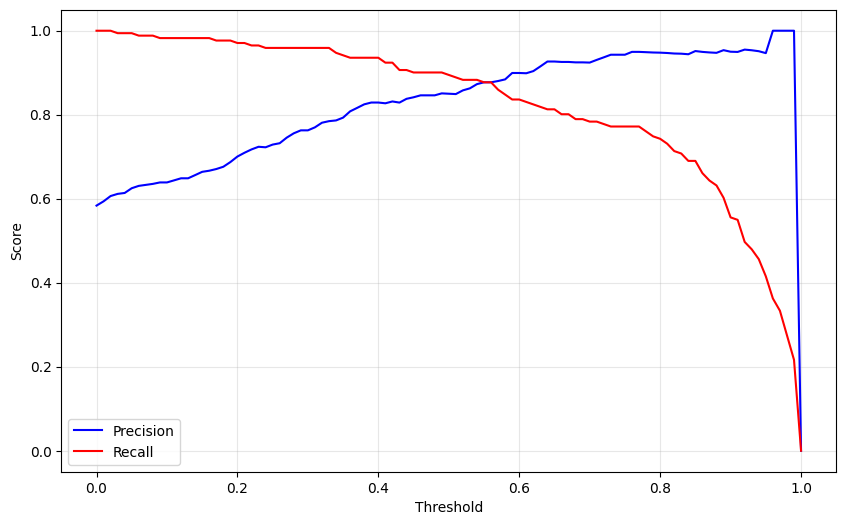

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [52]:
differences = np.abs(np.array(precisions) - np.array(recalls))
min_diff_idx = np.argmin(differences)
intersection_threshold = thresholds[min_diff_idx]

print(f"Intersection at threshold: {intersection_threshold:.3f}")
print(f"Precision: {precisions[min_diff_idx]:.3f}")
print(f"Recall: {recalls[min_diff_idx]:.3f}")

Intersection at threshold: 0.550
Precision: 0.877
Recall: 0.877


## Question 4: F1 Score

F1 = 2 * (P * R) / (P + R)

At which threshold is F1 maximal?

In [42]:
f1_scores = []

for i in range(len(thresholds)):
    p = precisions[i]
    r = recalls[i]
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

In [43]:
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_scores[max_f1_idx]

print(f"Maximum F1: {max_f1_value:.3f}")
print(f"Threshold: {max_f1_threshold:.2f}")

Maximum F1: 0.879
Threshold: 0.39


## Question 5: 5-Fold Cross-Validation

Use KFold with 5 splits to evaluate the model.

How large is the standard deviation of AUC scores across folds?

In [45]:
from sklearn.model_selection import KFold

In [46]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [50]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values

    dv, model = train(df_train_fold, y_train_fold, C=1.0)
    y_pred_fold = predict(df_val_fold, dv, model)

    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


In [51]:
np.std(scores)

np.float64(0.03580711942905165)

## Question 6: Hyperparameter Tuning

Use 5-Fold CV to find the best C parameter: [0.000001, 0.001, 1]

Which C leads to the best mean score?

In [49]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values

        dv, model = train(df_train_fold, y_train_fold, C=C)
        y_pred_fold = predict(df_val_fold, dv, model)

        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
